In [1]:
import random
import pandas as pd
import numpy as np
from collections import defaultdict

from Python_Scripts import OrderedCategorySystem as OCS
from Python_Scripts import generate_plots as plots
from Python_Scripts import order_analyses as analyses


## Setup

In [2]:
F =  [12, 13, 15, 14, 16, 18, 17, 19, 20]
B =  [20, 19, 17, 18, 16, 14, 15, 13, 12]
M1 =  [16, 17, 15, 18, 14, 19, 13, 20, 12]
M2 = [16, 15, 17, 14, 18, 13, 19, 12, 20]

NEW = [i for i in range(9, 24)]
ALL = NEW + [1, 3, 29, 31]

SHIFT = 3
DISTRACTORS = [1, 3, 29, 31]

conditions = {1: "2LF", 2: "2LM", 3: "2LB", 4: "2CF", 5: "2CM", 6: "2CB", 7: "2RF", 8: "2RM",
              9: "2RB", 10: "3LF", 11: "3LM", 12: "3LB", 13: "3CF", 14: "3CM", 15: "3CB", 16: "3RF",
              17: "3RM", 18: "3RB", 19: "2LA", 20: "2CA", 21: "2RA", 22: "3LA", 23: "3CA", 24: "3RA"}

ITEMS = ['I09', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18', 'I19', 'I20', 'I21', 'I22', 'I23']

LEFT = ITEMS[:9]
CENTRE = ITEMS[3:12]
RIGHT = ITEMS[6:]

LOCS = [('L', LEFT),
        ('C', CENTRE), 
        ('R', RIGHT)]
ORDERS = [('f', 0, [1, 2, 3, 4, 5, 6, 7, 8]),
          ('m', 4, [0, 1, 2, 3, 5, 6, 7, 8]),
          ('b', 8, [0, 1, 2, 3, 4, 5, 6, 7])]

item_space = [i for i in range(1, 32)]

## Functions

In [3]:
def get_item_set(order, loc):
    if order in ['F', 'B', 'M']: # Sequence
        if order == 'F':
            items = F
        elif order == 'B':
            items = B
        else: 
            items = random.choice([M1, M2])
        random.shuffle(DISTRACTORS)
        if loc == 'L':
            items = [i-SHIFT for i in items]
        elif loc == 'R':
            items = [i+SHIFT for i in items]
        return items[0:1] + DISTRACTORS[0:1] + items[1:4] + DISTRACTORS[1:2] + items[4:5] + DISTRACTORS[2:3] + items[5:8] + DISTRACTORS[3:4] + items[8:9]
    else: # All at once 
        items = F
        if loc == 'L':
            items = [i-SHIFT for i in items]
        elif loc == 'R':
            items = [i+SHIFT for i in items]
        final_set = items + DISTRACTORS
        random.shuffle(final_set)
        return final_set

def simulate_trials(conditions, softmax, temp=1.0, alpha=0.0):
    trials = []
    D, item_hash = OCS.get_distance_mat(item_space)
    treeCache = defaultdict(lambda: None)
    for i in range(len(conditions)):
        code = conditions[i]
        d, l, o = list(code)
        items = get_item_set(o, l)
        if d == '2':
            syst = OCS.CategorySystem(item_hash, 'Python_Scripts/BaseSystems/tree2D.json')
        else:
            syst = OCS.CategorySystem(item_hash, 'Python_Scripts/BaseSystems/tree3D.json')
        if softmax:
            score, cat_choices = OCS.greedy_categorizer_softmax(syst, items, D, treeCache, temp, alpha)
        else:
            score, cat_choices = OCS.greedy_categorizer(syst, items, D, treeCache)
        cat_choices['SCORE'] = score
        cat_choices['DEPTH'] = int(d)
        cat_choices['LOC'] = l
        cat_choices['ORDER'] = o.lower()
        cat_choices['P_ID'] = f's{i:03d}'
        cat_choices['POOL'] = 'simulated'
        cat_choices['STIMULI'] = 'simulated'
        trials.append(cat_choices)
        if i % 1000 == 0:
            print(f'{i+1} iteration(s) completed')
    df = pd.DataFrame.from_dict(trials)
    df = df[['P_ID', 'DEPTH', 'LOC', 'ORDER'] + [i for i in range(9, 24)] + [1, 3, 29, 31] + ['STIMULI', 'POOL', 'SCORE']]
    df.rename(columns={i:f'I{i:02}' for i in range(9, 24)}, inplace=True)
    df.rename(columns={1: 'I01', 3: 'I03', 29: 'I29', 31: 'I31'}, inplace=True)
    return df

## Simulations
Load trial types

In [4]:
allParticipants = pd.read_csv('Results/participant_data.csv')
allParticipants =  allParticipants[(allParticipants['ATTEMPTS'] < 3) & (allParticipants['TOTAL_ERRORS'] < 4)]
participants = allParticipants['P_ID'].tolist()

trials_df = pd.read_csv('Results/trial_data.csv')    
trials_df = trials_df[trials_df['P_ID'].isin(participants)][['DEPTH', 'LOC', 'ORDER']]

codes = trials_df["DEPTH"].astype(str) + trials_df["LOC"] + trials_df['ORDER'].str.upper()
codes = codes.tolist()

### Best fitting CKMM model
Softmax with T = 1.0, alpha = 0.15

1 iteration(s) completed
1001 iteration(s) completed


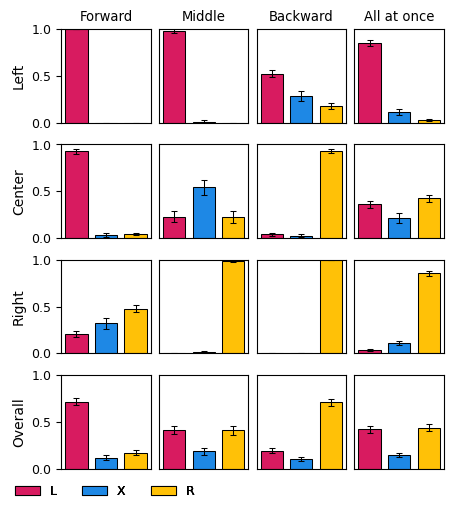

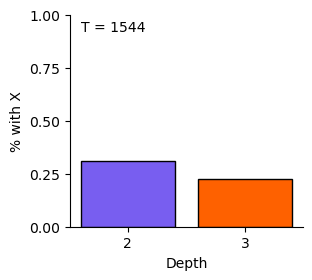

In [5]:
N = 1544
random.seed(1)
np.random.seed(1)
df_sm_full = simulate_trials(codes, True, temp=1.0)
df_sm = analyses.get_level2_cat_stats(df_sm_full, ITEMS)
plots.order_effects_plot(df_sm, fname='Figures/simulated_powerpoint.pdf', figsize=(4.4, 4.75), legend=True, show_counts=False)
plots.new_category_plot(df_sm, fname='Figures/best_simulated_X_by_depth.pdf', figsize=(3, 2.75))

In [6]:
print(round(df_sm[['DEPTH', 'HAS_X']].groupby(['DEPTH']).mean().reset_index(), 4))


   DEPTH   HAS_X
0      2  0.3083
1      3  0.2267


In [7]:
seq_df, _ = analyses.get_seq_data(df_sm, LOCS, ORDERS)
mean_prob = seq_df['PROP_SAME'].mean()
median_prob = seq_df['PROP_SAME'].median()
mode_probs = seq_df['PROP_SAME'].mode().values
all_same = seq_df[seq_df['PROP_SAME'] == 1].count()['PROP_SAME'] / seq_df.shape[0]
print(f'Percentage of trials where all are added to the same category: {round(all_same*100, 1)}%')

print(f'Mean: {mean_prob:.3f}')
print(f'Median items: {median_prob}')
print(f'Mode: {','.join([f'{m}' for m in mode_probs])}')

Percentage of trials where all are added to the same category: 66.0%
Mean: 0.819
Median items: 1.0
Mode: 1.0


In [19]:
left_f, left_m, left_b =  analyses.get_jsds(df_sm, 'L')
right_f, right_m, right_b =  analyses.get_jsds(df_sm, 'R')

table = pd.DataFrame({'': ['Left', 'Right'],
        'Forward': [round(left_f,3), round(right_f,3)],
        'Middle': [round(left_m,3), round(right_m, 3)],
        'Backward': [round(left_b, 3), round(right_b,3)]})

print(table.to_string(index=False))

       Forward  Middle  Backward
 Left    0.399   0.138     0.347
Right    0.386   0.148     0.380


In [20]:
round(df_sm_full[['LOC', 'SCORE']].groupby(['LOC']).max())

,SCORE
LOC,
C,2509.0
L,2567.0
R,2567.0
